In [1]:
import json
import itertools
import pandas as pd
import nltk
import re
import numpy as np
from sklearn.naive_bayes import GaussianNB
from matplotlib.widgets import CheckButtons
from gensim.models import Word2Vec
from operator import itemgetter
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from PIL import Image
from sklearn.decomposition import PCA
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

/Users/jalexander/Projects/python36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/jalexander/Projects/python36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
## GLOBALS 
%matplotlib notebook  
# CONFIG
TRAINING_DATA_DIR="./datasets/BioASQ-trainingDataset6b.json"
# TFIDF CONFIG
TOP_N=5
MIN_DF=0.01
MAX_DF=1.00
N_GRAMS=[(1,1),(2,2),(3,3),(1,3)]
BUILD_WORD_CLOUD=False

In [7]:
### FUNCIONS
def build_vector_model(questions):
    questions = [tokenize(q) for q in questions]
    model = Word2Vec(questions, min_count=0, sg=0)
    question_vectors = []
    for question in questions:
        question_vector = []
        for word in question:
            question_vector = model[word] if (len(question_vector) == 0) else np.add(question_vector, model[word])
        question_vectors.append(question_vector)
    return question_vectors        

def parse_questions_types(data):
    return zip(*[[json['body'], json['type']] for json in data['questions']])

def label_to_class(str_labels, label):
    return str_labels.index(label)

def build_tfidf_weights(sent_list, min_df, max_df, ngram, top_n=25):
    tfidf_vectorizer = TfidfVectorizer(
        max_df=max_df, 
        min_df=min_df, 
        tokenizer=tokenize, 
        ngram_range=ngram
    )
    tfidf = tfidf_vectorizer.fit_transform(sent_list)
    terms = tfidf_vectorizer.get_feature_names()
    return top_mean_feats(tfidf, terms, top_n=top_n)

def build_word_cloud(tfidf_weights, output_file):
    # Initialize the word cloud
    wc = WordCloud(
        background_color="white",
        max_words=1000,
        width = 1024,
        height = 720,
    )
    wc.generate_from_frequencies(tfidf_weights)
    wc.to_file(output_file)

def json_to_df(json_file_path):
    with open(json_file_path, 'r') as f:
        return pd.DataFrame(json.load(f))
    
def build_features(X):
    return {
        len(X)
    }

def top_mean_feats(Xtr, features, grp_ids=None, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_tfidf_feats(row, features, top_n):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    feats = {}
    topn_ids = np.argsort(row)[::-1][:top_n]
    for i in topn_ids:
        feats[features[i]] = row[i]

    return feats

def tokenize(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token)  and len(token) > 3:
            filtered_tokens.append(token)
        
    return filtered_tokens

build_features('Is Hirschsprung disease a mendelian or a multifactorial disorder?')

{65}

In [4]:
# DATA ANALYSIS
[questions, q_types] = parse_questions_types(json_to_df(TRAINING_DATA_DIR))
str_labels = list(np.unique(q_types))
print("Labels")
print(str_labels)
print()
y = [label_to_class(str_labels, q_type) for q_type in q_types]

for label in str_labels:
    label_questions = [questions[idx] for idx, q_type in enumerate(q_types) if q_type == label]
    count = len(label_questions)   
    average_question_length = np.average([len(q) for q in label_questions])
    tfidf_weights = []

    for ngram in N_GRAMS:
        weights = build_tfidf_weights(label_questions, MIN_DF, MAX_DF, ngram, TOP_N) 
        tfidf_weights.append(weights)
    
        if BUILD_WORD_CLOUD:
            build_word_cloud(weights, f"{label}_{ngram}_world_cloud.png")

    # Logging
    print(f"Label Analysis: {label}")        
    print(f"Count: {count}")
    print(f"Average question length: {average_question_length}")
    for idx, ngram in enumerate(N_GRAMS):
        print(f"TFIDF NGRAM={ngram}: {tfidf_weights[idx]}")
    print()

Labels
['factoid', 'list', 'summary', 'yesno']

Label Analysis: factoid
Count: 619
Average question length: 62.19386106623586
TFIDF NGRAM=(1, 1): {'which': 0.17666687585992275, 'what': 0.16804829722323097, 'protein': 0.05726073370604774, 'with': 0.049438105331838546, 'syndrome': 0.04942448472129576}
TFIDF NGRAM=(2, 2): {'associated with': 0.04254730612446574, 'which gene': 0.04132425619574248, 'which protein': 0.035108389110929124, 'which disease': 0.03051130393655959, 'which enzyme': 0.02347120926424941}
TFIDF NGRAM=(3, 3): {'what mode inheritance': 0.01615508885298869, 'which most common': 0.011308562197092083, 'which enzyme inhibited': 0.011308562197092083, 'which disease treated': 0.007996361015033654, 'disease treated with': 0.007996361015033654}
TFIDF NGRAM=(1, 3): {'which': 0.16344724302352973, 'what': 0.15964600058487446, 'protein': 0.052277843570378124, 'syndrome': 0.04561186731794573, 'with': 0.04239845176921369}

Label Analysis: list
Count: 485
Average question length: 66.31

/Users/jalexander/Projects/python36/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


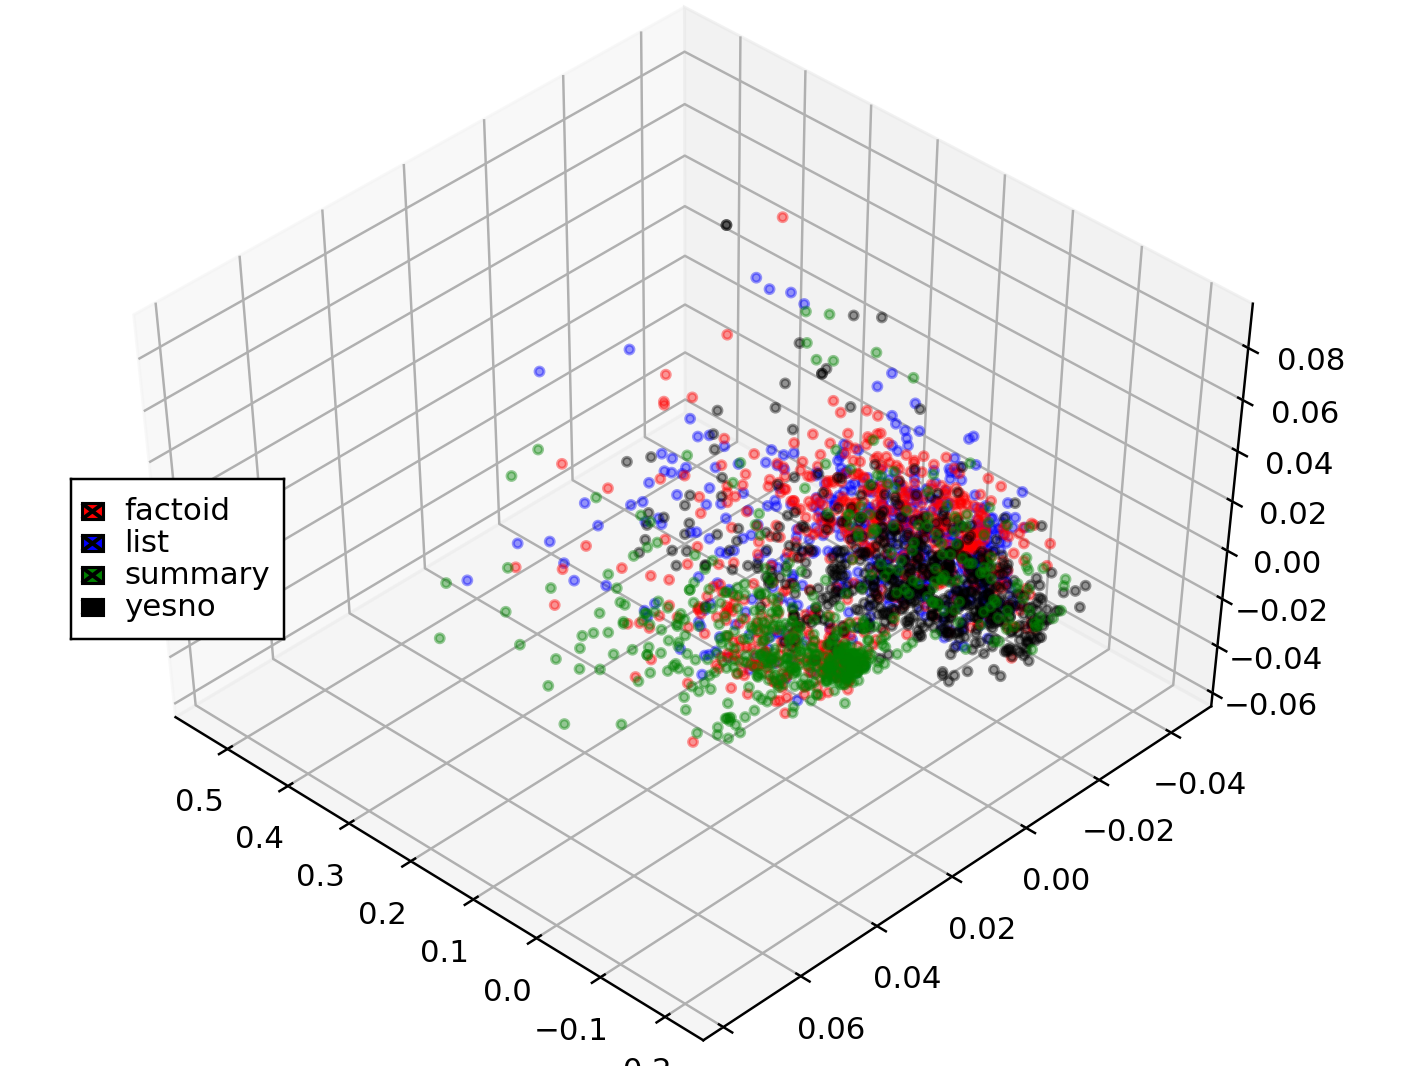

In [8]:
# MODEL BUILDING
[questions, q_types] = parse_questions_types(json_to_df(TRAINING_DATA_DIR))
str_labels = list(np.unique(q_types))
question_vectors = build_vector_model(questions)

# PCA
pca = PCA(n_components=4)
pca.fit(question_vectors)
pca_res = pca.transform(question_vectors)

# Plotting result
pyplot.cla(); pyplot.clf();
fig = pyplot.figure(1, figsize=(10, 10))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
colors = {
    'factoid': 'red', 
    'list': 'blue', 
    'summary': 'green', 
    'yesno': 'black'
}
indexes = {
    'factoid': [], 
    'list': [], 
    'summary': [], 
    'yesno': []
}
series = {
    'factoid': [], 
    'list': [], 
    'summary': [], 
    'yesno': []
}

def check_func(label):
    l_series = series[label]
    l_series.set_visible(not l_series.get_visible())

[indexes[label].append(idx) for idx, label in enumerate(q_types)]

for label in str_labels:
    idx = indexes[label]
    series[label] = ax.scatter(pca_res[idx, 0], pca_res[idx, 1], pca_res[idx, 2], color=colors[label], s=8, alpha=0.4)

rax = pyplot.axes([0.05, 0.4, 0.15, 0.15])
check = CheckButtons(rax, ('factoid', 'list', 'summary', 'yesno'), (True, True, True, True))        
[rec.set_facecolor(colors[label]) for label, rec in zip(str_labels, check.rectangles)]
check.on_clicked(check_func)
pyplot.show()

In [9]:
# MODEL TESTING
[questions, q_types] = parse_questions_types(json_to_df(TRAINING_DATA_DIR))
X = build_vector_model(questions)
str_labels = list(np.unique(q_types))
y = [label_to_class(str_labels, q_type) for q_type in q_types]

# PCA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

pca = PCA(n_components=4)
pca.fit(X_train)
X_train_tr = pca.transform(X_train)
X_test_tr = pca.transform(X_test)

# search for optimal SVM parameters using grid search with 3-fold cross validation
Cs = np.logspace(0, 4, 4)
gammas = np.logspace(0, 3, 4)
param_grid = {'C': Cs, 'kernel': ['linear','rbf'], 'gamma': gammas}
clf = GridSearchCV(estimator=SVC(), param_grid=param_grid)
clf.fit(X_train_tr, y_train)
y_hat = clf.predict(X_test_tr)
print(clf.best_estimator_)
print(classification_report(y_test, y_hat, target_names=np.unique(q_types)))

/Users/jalexander/Projects/python36/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/Users/jalexander/Projects/python36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


SVC(C=10000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
              precision    recall  f1-score   support

     factoid       0.51      0.51      0.51        57
        list       0.62      0.11      0.19        45
     summary       0.65      0.68      0.66        62
       yesno       0.61      0.95      0.75        62

   micro avg       0.60      0.60      0.60       226
   macro avg       0.60      0.56      0.53       226
weighted avg       0.60      0.60      0.55       226



In [40]:
# KNN()
clf = KNeighborsClassifier(n_neighbors=4)
clf.fit(X_train_tr, y_train)
y_hat = clf.predict(X_test_tr)
print(classification_report(y_test, y_hat, target_names=np.unique(q_types)))

              precision    recall  f1-score   support

     factoid       0.38      0.57      0.46        61
        list       0.38      0.29      0.32        42
     summary       0.63      0.46      0.53        59
       yesno       0.64      0.59      0.62        64

   micro avg       0.50      0.50      0.50       226
   macro avg       0.51      0.48      0.48       226
weighted avg       0.52      0.50      0.50       226



In [10]:
# GaussianNB()
clf = GaussianNB()
clf.fit(X_train_tr, y_train)
y_hat = clf.predict(X_test_tr)
print(classification_report(y_test, y_hat, target_names=np.unique(q_types)))

              precision    recall  f1-score   support

     factoid       0.43      0.35      0.38        57
        list       0.50      0.31      0.38        45
     summary       0.65      0.68      0.66        62
       yesno       0.65      0.90      0.76        62

   micro avg       0.58      0.58      0.58       226
   macro avg       0.56      0.56      0.55       226
weighted avg       0.56      0.58      0.56       226



In [11]:
# DecisionTree
clf = DecisionTreeClassifier()
clf.fit(X_train_tr, y_train)
y_hat = clf.predict(X_test_tr)
print(classification_report(y_test, y_hat, target_names=np.unique(q_types)))

              precision    recall  f1-score   support

     factoid       0.34      0.44      0.38        57
        list       0.29      0.24      0.27        45
     summary       0.45      0.45      0.45        62
       yesno       0.62      0.52      0.56        62

   micro avg       0.42      0.42      0.42       226
   macro avg       0.42      0.41      0.41       226
weighted avg       0.44      0.42      0.43       226

